<a href="https://colab.research.google.com/github/nailfurkanacar/stock-price-prediction/blob/main/multivariate_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab auth and path

connect the drive to get the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = 'drive/My Drive/Colab Notebooks/Senior Project'

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Libraries

In [ ]:
import pandas as pd
import numpy as np
import math


import matplotlib.pyplot as plt
import matplotlib.dates 
import seaborn as sns
#from statsmodels.tsa.seasonal import STL

from datetime import datetime
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from kerastuner.tuners import RandomSearch

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
pip install -U keras-tuner


In [ ]:
print(tf.__version__)

2.6.0


In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Sorting and Filtering

In [ ]:
# dataların dizilisini gunumuzden gecmise siralama

def data_sorter(table):
    table = table[::-1] 
    table.reset_index(inplace=True, drop=True)  #to reset the dataframe
    return table

In [ ]:
# to set the time filter for the dataframes

def data_filter_by_time(table):
    start = pd.to_datetime('1986-01-01')
    end = pd.to_datetime('2017-07-14') 
    table = table.loc[(table['Date'] >= start) & (table['Date'] <= end)] 
    table.reset_index(inplace=True, drop=True)
    return table

# FEDFUNDS

In [ ]:
fedfunds = pd.read_csv(path + '/FEDFUNDS.csv') #fred.stlouisfed.org 'dan elde edildi, Intereset rate

fedfunds # aylık degisiyor

,DATE,FEDFUNDS
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83
...,...,...
794,2020-09-01,0.09
795,2020-10-01,0.09
796,2020-11-01,0.09
797,2020-12-01,0.09


In [ ]:
fedfunds.rename(columns={'DATE':'Date', 'FEDFUNDS':'fedfunds'}, inplace = True)
fedfunds['Date'] = pd.to_datetime(fedfunds['Date'], format = '%Y-%m-%d')  #tarih formatlarini ayni formata getirme
fedfunds

,Date,fedfunds
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83
...,...,...
794,2020-09-01,0.09
795,2020-10-01,0.09
796,2020-11-01,0.09
797,2020-12-01,0.09


In [ ]:
fedfunds = data_sorter(fedfunds) 

In [ ]:
fedfunds = data_filter_by_time(fedfunds)

In [ ]:
fedfunds

,Date,fedfunds
0,2017-07-01,1.15
1,2017-06-01,1.04
2,2017-05-01,0.91
3,2017-04-01,0.90
4,2017-03-01,0.79
...,...,...
374,1986-05-01,6.85
375,1986-04-01,6.99
376,1986-03-01,7.48
377,1986-02-01,7.86


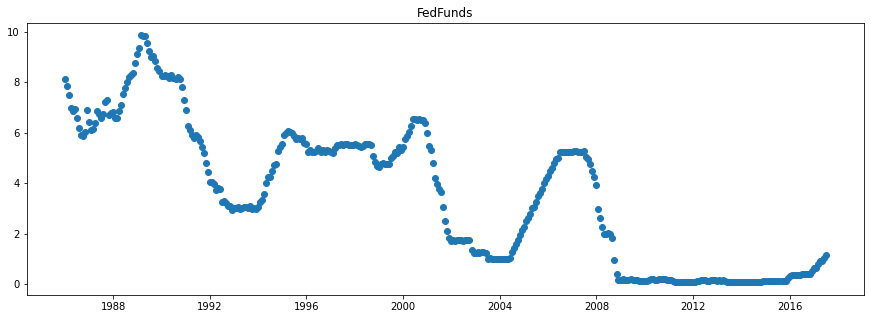

In [ ]:
plt.figure(figsize=(15,5))
plt.title('FedFunds')
plt.scatter(x="Date", y = "fedfunds", data = fedfunds)

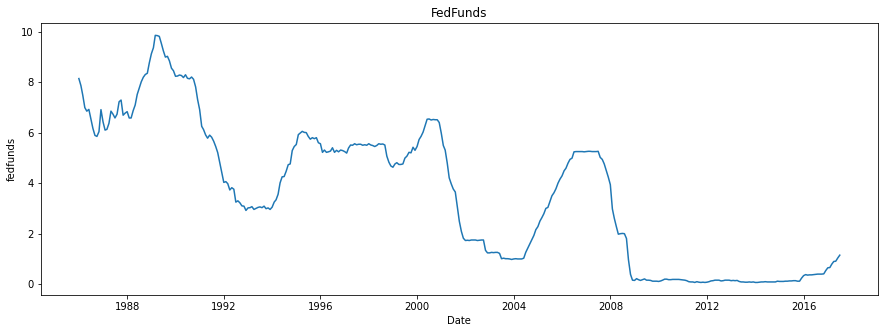

In [ ]:
plt.figure(figsize=(15,5))
plt.title('FedFunds')
sns.lineplot(x="Date", y = "fedfunds", data = fedfunds)

In [ ]:
fedfunds.dtypes

Date        datetime64[ns]
fedfunds           float64
dtype: object

# xau_usd_v2

In [ ]:
# https://stooq.com/q/d/l/?s=xauusd&d1=19700101&d2=20210316&i=d

In [ ]:
xau_usd_v2 = pd.read_csv(path + '/xauusd_d.csv') #gunluk degisiyor
xau_usd_v2

,Date,Open,High,Low,Close
0,1970-01-05,35.40,35.40,35.40,35.40
1,1970-01-06,35.40,35.40,35.20,35.20
2,1970-01-07,35.20,35.20,35.20,35.20
3,1970-01-08,35.20,35.20,35.10,35.10
4,1970-01-09,35.10,35.10,35.10,35.10
...,...,...,...,...,...
13022,2021-03-09,1683.48,1720.69,1680.31,1716.17
13023,2021-03-10,1716.11,1726.89,1708.26,1726.72
13024,2021-03-11,1726.76,1739.91,1719.47,1722.60
13025,2021-03-12,1722.34,1727.98,1699.35,1724.54


In [ ]:
xau_usd_v2['Date'] = pd.to_datetime(xau_usd_v2['Date'], format = '%Y-%m-%d') #tarih formatlarini ayni formata getirme

In [ ]:
xau_usd_v2.drop(["Open", "High", "Low"],axis = 1, inplace = True) 

In [ ]:
xau_usd_v2.rename(columns={"Close": "xau_usd"}, inplace = True)

In [ ]:
xau_usd_v2 = data_filter_by_time(xau_usd_v2)

In [ ]:
xau_usd_v2 = data_sorter(xau_usd_v2)

In [ ]:
#pd.set_option('display.max_rows', None)  #bütün datayı gösterebilmek için
xau_usd_v2

,Date,xau_usd
0,2017-07-14,1228.47
1,2017-07-13,1217.57
2,2017-07-12,1218.29
3,2017-07-11,1218.18
4,2017-07-10,1214.39
...,...,...
8070,1986-01-08,336.10
8071,1986-01-07,332.80
8072,1986-01-06,330.70
8073,1986-01-03,330.00


In [ ]:
xau_usd_v2.dtypes

Date       datetime64[ns]
xau_usd           float64
dtype: object

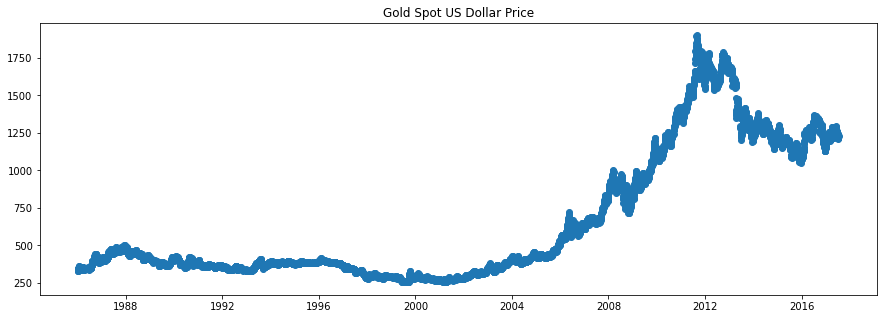

In [ ]:
plt.figure(figsize=(15,5))
plt.title('Gold Spot US Dollar Price')
plt.scatter(x="Date", y="xau_usd", data = xau_usd_v2)

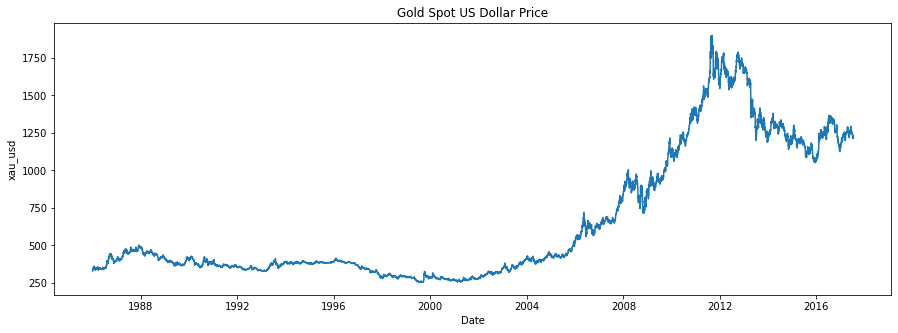

In [ ]:
plt.figure(figsize=(15,5))
plt.title('Gold Spot US Dollar Price')
sns.lineplot(x="Date", y = "xau_usd", data = xau_usd_v2)

# Gross Domestic Product(GDP) of US 

In [ ]:
gdp_us = pd.read_csv(path + '/UNAE-GDPCDPC_USA.csv') #GDP degerleri, yıllık degisiyor 2020 yok, 2020 yerine 2019
gdp_us.head(10)

,Date,Gross Domestic Product (GDP)
0,2019-12-31,65133.731652
1,2018-12-31,63014.663283
2,2017-12-31,60116.568493
3,2016-12-31,58031.414203
4,2015-12-31,56838.684422
5,2014-12-31,55000.691601
6,2013-12-31,53049.375662
7,2012-12-31,51575.616573
8,2011-12-31,49882.470395
9,2010-12-31,48516.165945


In [ ]:
gdp_us.rename(columns={'Gross Domestic Product (GDP)':'GDP'}, inplace = True)

In [ ]:
gdp_us['Date'] = pd.to_datetime(gdp_us['Date'], format = '%Y-%m-%d') #tarih formatlarini ayni formata getirme
gdp_us.dtypes

Date    datetime64[ns]
GDP            float64
dtype: object

In [ ]:
gdp_us = data_filter_by_time(gdp_us)
gdp_us.head(10)

,Date,GDP
0,2016-12-31,58031.414203
1,2015-12-31,56838.684422
2,2014-12-31,55000.691601
3,2013-12-31,53049.375662
4,2012-12-31,51575.616573
5,2011-12-31,49882.470395
6,2010-12-31,48516.165945
7,2009-12-31,47171.319147
8,2008-12-31,48479.483133
9,2007-12-31,48075.365179


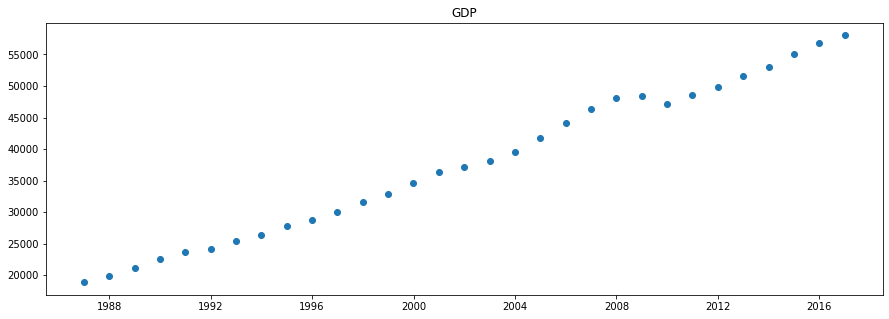

In [ ]:
plt.figure(figsize=(15,5))
plt.title('GDP')
plt.scatter(x="Date", y="GDP", data = gdp_us)

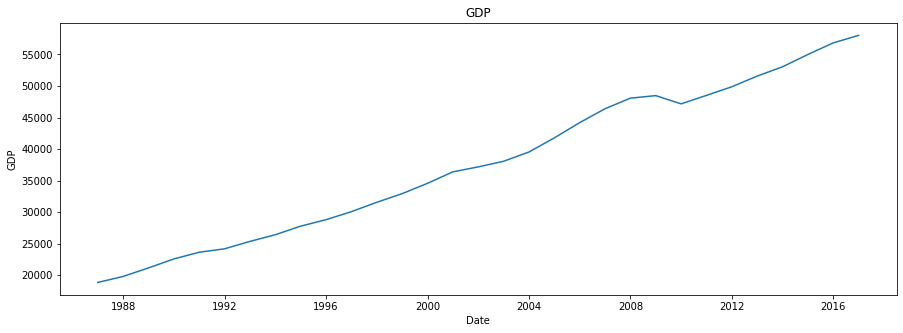

In [ ]:
plt.figure(figsize=(15,5))
plt.title('GDP')
sns.lineplot(x="Date", y="GDP", data = gdp_us)

# Consumer Price Index(CPI) values of US

In [ ]:
cpi_us = pd.read_csv(path + '/RATEINF-CPI_USA.csv') #aylık degisiyor
cpi_us

,Date,Value
0,2021-01-31,261.582
1,2020-12-31,260.474
2,2020-11-30,260.229
3,2020-10-31,260.388
4,2020-09-30,260.280
...,...,...
1292,1913-05-31,9.700
1293,1913-04-30,9.800
1294,1913-03-31,9.800
1295,1913-02-28,9.800


In [ ]:
cpi_us.rename(columns={'Value':'CPI'}, inplace = True)

In [ ]:
cpi_us['Date'] = pd.to_datetime(cpi_us['Date'], format = '%Y-%m-%d') #tarih formatlarini ayni formata getirme
cpi_us.dtypes 

Date    datetime64[ns]
CPI            float64
dtype: object

In [ ]:
cpi_us = data_filter_by_time(cpi_us)
cpi_us

,Date,CPI
0,2017-06-30,244.955
1,2017-05-31,244.733
2,2017-04-30,244.524
3,2017-03-31,243.801
4,2017-02-28,243.603
...,...,...
373,1986-05-31,108.900
374,1986-04-30,108.600
375,1986-03-31,108.800
376,1986-02-28,109.300


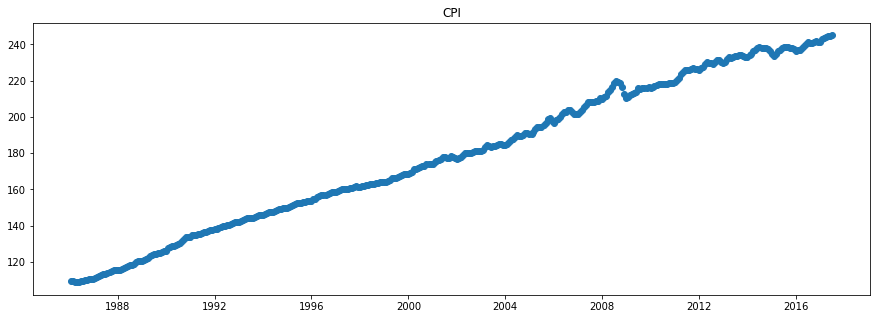

In [ ]:
plt.figure(figsize=(15,5))
plt.title('CPI')
plt.scatter(x="Date", y = "CPI", data = cpi_us)

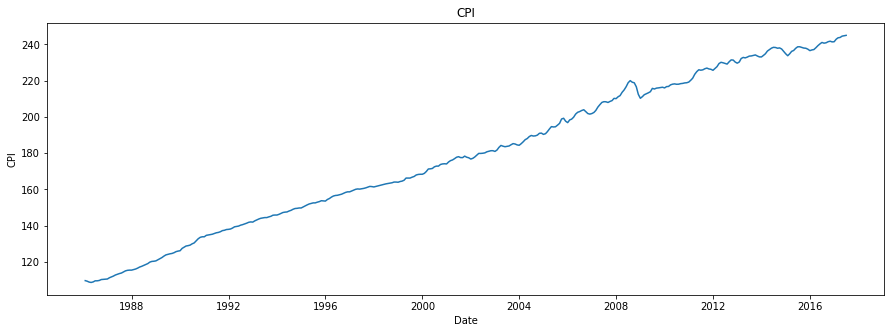

In [ ]:
plt.figure(figsize=(15,5))
plt.title('CPI')
sns.lineplot(x="Date", y = "CPI", data = cpi_us)

# Inflation Ratio of US

In [ ]:
# https://fred.stlouisfed.org/series/FPCPITOTLZGUSA

In [ ]:
inflation_us = pd.read_csv(path + '/inflation_rate_us.csv') #enflasyon(US) verileri mevcut ve yıllık değişiyor
inflation_us

,DATE,FPCPITOTLZGUSA
0,1960-01-01,1.457976
1,1961-01-01,1.070724
2,1962-01-01,1.198773
3,1963-01-01,1.239669
4,1964-01-01,1.278912
...,...,...
57,2017-01-01,2.130110
58,2018-01-01,2.442583
59,2019-01-01,1.812210
60,2020-01-01,0.620000


In [ ]:
inflation_us.rename(columns={'DATE':'Date', 'FPCPITOTLZGUSA' : 'Inflation_Rate'}, inplace = True)

In [ ]:
inflation_us['Date'] = pd.to_datetime(inflation_us['Date'], format = '%Y-%m-%d') #tarih formatlarini ayni formata getirme
inflation_us.dtypes

Date              datetime64[ns]
Inflation_Rate           float64
dtype: object

In [ ]:
inflation_us = data_sorter(inflation_us)

In [ ]:
inflation_us = data_filter_by_time(inflation_us)

In [ ]:
inflation_us.head(10)

,Date,Inflation_Rate
0,2017-01-01,2.130110
1,2016-01-01,1.261583
2,2015-01-01,0.118627
3,2014-01-01,1.622223
4,2013-01-01,1.464833
5,2012-01-01,2.069337
6,2011-01-01,3.156842
7,2010-01-01,1.640043
8,2009-01-01,-0.355546
9,2008-01-01,3.839100


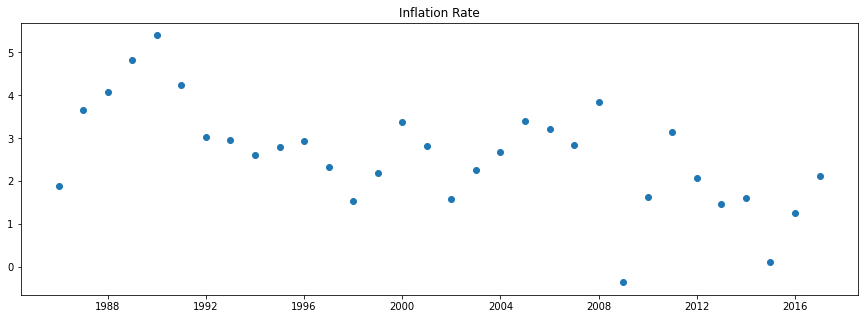

In [ ]:
plt.figure(figsize=(15,5))
plt.title('Inflation Rate')
plt.scatter(x="Date", y = "Inflation_Rate", data = inflation_us)

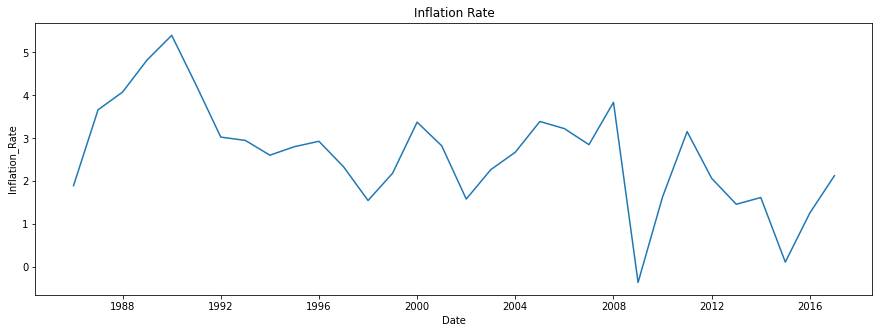

In [ ]:
plt.figure(figsize=(15,5))
plt.title('Inflation Rate')
sns.lineplot(x="Date", y = "Inflation_Rate", data = inflation_us)

# IXIC - NASDAQ

In [ ]:
nasdaq_all = pd.read_csv(path + '/IXIC_402.csv') #yahoo finance 'den elde edildi (date range: max : 1971-2021)
#nasdaq = pd.read_csv(path + '/AAL.csv') #yahoo finance 'den elde edildi 
nasdaq_all

,Date,Open,High,Low,Close,Adj Close,Volume
0,1971-02-05,100.000000,100.000000,100.000000,100.000000,100.000000,0
1,1971-02-08,100.839996,100.839996,100.839996,100.839996,100.839996,0
2,1971-02-09,100.760002,100.760002,100.760002,100.760002,100.760002,0
3,1971-02-10,100.690002,100.690002,100.690002,100.690002,100.690002,0
4,1971-02-11,101.449997,101.449997,101.449997,101.449997,101.449997,0
...,...,...,...,...,...,...,...
12719,2021-07-13,14715.129883,14803.679688,14660.190430,14677.650391,14677.650391,4553380000
12720,2021-07-14,14780.900391,14790.549805,14632.950195,14644.950195,14644.950195,4461730000
12721,2021-07-15,14635.780273,14650.370117,14451.799805,14543.129883,14543.129883,4493540000
12722,2021-07-16,14597.509766,14623.019531,14413.320313,14427.240234,14427.240234,4048940000


In [ ]:
nasdaq = nasdaq_all
nasdaq.drop(["Open", "High", "Low", "Adj Close"], axis = 1, inplace = True)  #fiyat bilgisi icin "Close" kullanildi

nasdaq['Date'] = pd.to_datetime(nasdaq['Date'], format = '%Y-%m-%d') #tarih formatlarini ayni formata getirme
nasdaq.dtypes

Date      datetime64[ns]
Close            float64
Volume             int64
dtype: object

In [ ]:
nasdaq = data_sorter(nasdaq)

In [ ]:
nasdaq = data_filter_by_time(nasdaq)

In [ ]:
nasdaq

,Date,Close,Volume
0,2017-07-14,6312.470215,1608120000
1,2017-07-13,6274.439941,1803810000
2,2017-07-12,6261.169922,1820550000
3,2017-07-11,6193.299805,1808110000
4,2017-07-10,6176.390137,1675470000
...,...,...,...
7945,1986-01-08,328.100006,140000000
7946,1986-01-07,329.700012,127500000
7947,1986-01-06,326.000000,99240000
7948,1986-01-03,325.700012,89180000


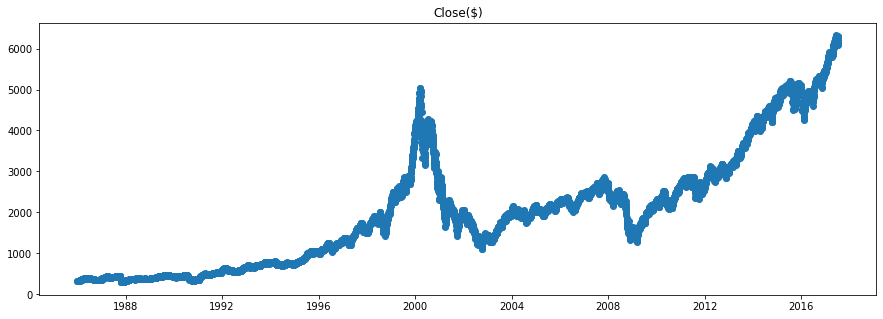

In [ ]:
plt.figure(figsize=(15,5))
plt.title('Close($)')
plt.scatter(x="Date", y="Close", data = nasdaq)

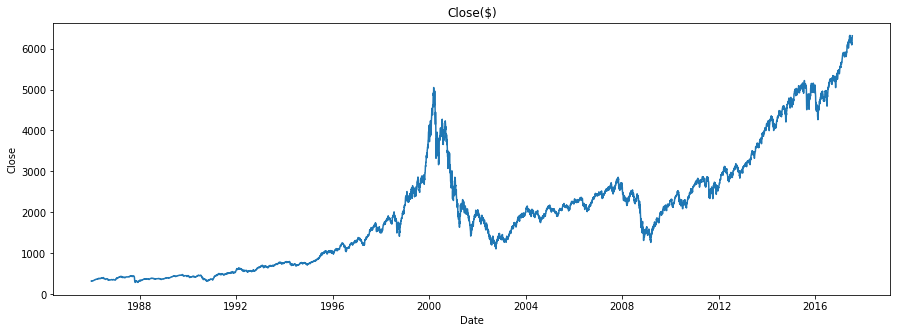

In [ ]:
plt.figure(figsize=(15,5))
plt.title('Close($)')
sns.lineplot(x="Date", y="Close", data = nasdaq)

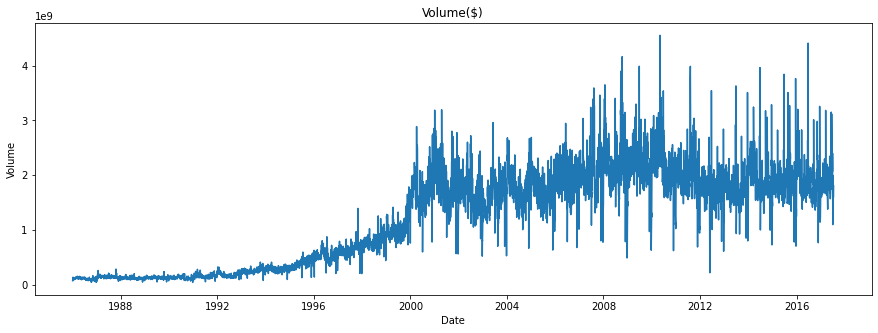

In [ ]:
plt.figure(figsize=(15,5))
plt.title('Volume($)')
sns.lineplot(x="Date", y="Volume", data = nasdaq)

In [ ]:
nasdaq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7950 entries, 0 to 7949
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    7950 non-null   datetime64[ns]
 1   Close   7950 non-null   float64       
 2   Volume  7950 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 186.5 KB


In [ ]:
nasdaq.describe()

,Close,Volume
count,7950.000000,7.950000e+03
mean,2013.939792,1.212732e+09
std,1421.590595,8.460065e+08
min,291.899994,4.404000e+07
25%,727.529984,2.700425e+08
50%,1894.525024,1.476165e+09
75%,2649.560059,1.902535e+09
max,6321.759766,4.553600e+09


In [ ]:
nasdaq.isnull().any()

Date      False
Close     False
Volume    False
dtype: bool

# Concetination of DataFrames

In [ ]:
#“Merging” two datasets is the process of bringing two datasets together into one
# outer: use union of keys from both frames,

all_data = pd.merge(nasdaq, fedfunds, how ="outer", on=["Date"]) 
all_data = pd.merge(all_data, xau_usd_v2, how ="outer", on=["Date"])
all_data = pd.merge(all_data, gdp_us, how ="outer", on=["Date"])
all_data = pd.merge(all_data, cpi_us, how ="outer", on=["Date"])
all_data = pd.merge(all_data, inflation_us, how="outer", on=["Date"])

In [ ]:
all_data = all_data.sort_values(by='Date')
#all_data = data_sorter(all_data)
all_data = data_filter_by_time(all_data)

In [ ]:
#pd.set_option('display.max_rows', None)  #bütün datayı gösterebilmek için
all_data

,Date,Close,Volume,fedfunds,xau_usd,GDP,CPI,Inflation_Rate
0,1986-01-01,NaN,NaN,8.14,NaN,NaN,NaN,1.898048
1,1986-01-02,325.000000,7.581000e+07,NaN,328.90,NaN,NaN,NaN
2,1986-01-03,325.700012,8.918000e+07,NaN,330.00,NaN,NaN,NaN
3,1986-01-06,326.000000,9.924000e+07,NaN,330.70,NaN,NaN,NaN
4,1986-01-07,329.700012,1.275000e+08,NaN,332.80,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
8352,2017-07-10,6176.390137,1.675470e+09,NaN,1214.39,NaN,NaN,NaN
8353,2017-07-11,6193.299805,1.808110e+09,NaN,1218.18,NaN,NaN,NaN
8354,2017-07-12,6261.169922,1.820550e+09,NaN,1218.29,NaN,NaN,NaN
8355,2017-07-13,6274.439941,1.803810e+09,NaN,1217.57,NaN,NaN,NaN


In [ ]:
columns_for_previos = ["Close", "Volume", "fedfunds", "xau_usd", "GDP","CPI", "Inflation_Rate"]
all_data.update(all_data[columns_for_previos].fillna(method="bfill",axis=0))

In [ ]:
all_data

,Date,Close,Volume,fedfunds,xau_usd,GDP,CPI,Inflation_Rate
0,1986-01-01,325.000000,7.581000e+07,8.14,328.90,18864.60543,109.6,1.898048
1,1986-01-02,325.000000,7.581000e+07,7.86,328.90,18864.60543,109.6,3.664563
2,1986-01-03,325.700012,8.918000e+07,7.86,330.00,18864.60543,109.6,3.664563
3,1986-01-06,326.000000,9.924000e+07,7.86,330.70,18864.60543,109.6,3.664563
4,1986-01-07,329.700012,1.275000e+08,7.86,332.80,18864.60543,109.6,3.664563
...,...,...,...,...,...,...,...,...
8352,2017-07-10,6176.390137,1.675470e+09,NaN,1214.39,NaN,NaN,NaN
8353,2017-07-11,6193.299805,1.808110e+09,NaN,1218.18,NaN,NaN,NaN
8354,2017-07-12,6261.169922,1.820550e+09,NaN,1218.29,NaN,NaN,NaN
8355,2017-07-13,6274.439941,1.803810e+09,NaN,1217.57,NaN,NaN,NaN


In [ ]:
#pd.set_option('display.max_rows', None)  #bütün datayı gösterebilmek için
all_data.tail(10)

,Date,Close,Volume,fedfunds,xau_usd,GDP,CPI,Inflation_Rate
8347,2017-07-03,6110.060059,1.099560e+09,NaN,1219.22,NaN,NaN,NaN
8348,2017-07-04,6150.859863,1.872130e+09,NaN,1223.98,NaN,NaN,NaN
8349,2017-07-05,6150.859863,1.872130e+09,NaN,1227.35,NaN,NaN,NaN
8350,2017-07-06,6089.459961,1.990590e+09,NaN,1224.60,NaN,NaN,NaN
8351,2017-07-07,6153.080078,1.700630e+09,NaN,1211.97,NaN,NaN,NaN
8352,2017-07-10,6176.390137,1.675470e+09,NaN,1214.39,NaN,NaN,NaN
8353,2017-07-11,6193.299805,1.808110e+09,NaN,1218.18,NaN,NaN,NaN
8354,2017-07-12,6261.169922,1.820550e+09,NaN,1218.29,NaN,NaN,NaN
8355,2017-07-13,6274.439941,1.803810e+09,NaN,1217.57,NaN,NaN,NaN
8356,2017-07-14,6312.470215,1.608120e+09,NaN,1228.47,NaN,NaN,NaN


In [ ]:
all_data.update(all_data.GDP.interpolate())
all_data.update(all_data.CPI.interpolate())

In [ ]:
all_data = all_data.fillna(method="ffill", axis=0)

In [ ]:
all_data.dropna(how="any", inplace=True) #thresh: En az iki düzgün veri var ise silme, axis=0: satır
all_data.reset_index(inplace=True, drop=True)

In [ ]:
all_data.tail(20)

,Date,Close,Volume,fedfunds,xau_usd,GDP,CPI,Inflation_Rate
8337,2017-06-20,6188.029785,2.570130e+09,1.15,1243.68,58031.414203,244.955,2.13011
8338,2017-06-21,6233.950195,2.401440e+09,1.15,1247.68,58031.414203,244.955,2.13011
8339,2017-06-22,6236.689941,2.170250e+09,1.15,1250.58,58031.414203,244.955,2.13011
8340,2017-06-23,6265.250000,2.704600e+09,1.15,1255.86,58031.414203,244.955,2.13011
8341,2017-06-26,6247.149902,2.150630e+09,1.15,1245.31,58031.414203,244.955,2.13011
8342,2017-06-27,6146.620117,2.181830e+09,1.15,1247.63,58031.414203,244.955,2.13011
8343,2017-06-28,6234.410156,2.069400e+09,1.15,1249.49,58031.414203,244.955,2.13011
8344,2017-06-29,6144.350098,2.402250e+09,1.15,1244.72,58031.414203,244.955,2.13011
8345,2017-06-30,6140.419922,1.998330e+09,1.15,1241.38,58031.414203,244.955,2.13011
8346,2017-07-01,6110.060059,1.099560e+09,1.15,1219.22,58031.414203,244.955,2.13011


In [ ]:
all_data.corr()

,Close,Volume,fedfunds,xau_usd,GDP,CPI,Inflation_Rate
Close,1.000000,0.696980,-0.617178,0.642889,0.869729,0.851358,-0.535335
Volume,0.696980,1.000000,-0.701431,0.551859,0.861900,0.853647,-0.531597
fedfunds,-0.617178,-0.701431,1.000000,-0.710357,-0.814604,-0.839566,0.689426
xau_usd,0.642889,0.551859,-0.710357,1.000000,0.776450,0.792526,-0.477835
GDP,0.869729,0.861900,-0.814604,0.776450,1.000000,0.994871,-0.628495
CPI,0.851358,0.853647,-0.839566,0.792526,0.994871,1.000000,-0.663824
Inflation_Rate,-0.535335,-0.531597,0.689426,-0.477835,-0.628495,-0.663824,1.000000


In [ ]:
all_data.cov()

,Close,Volume,fedfunds,xau_usd,GDP,CPI,Inflation_Rate
Close,2.016869e+06,8.340995e+11,-2.418806e+03,3.966339e+05,1.486405e+07,4.888771e+04,-9.137749e+02
Volume,8.340995e+11,7.100974e+17,-1.631157e+09,2.020233e+11,8.740376e+12,2.908614e+10,-5.384139e+08
fedfunds,-2.418806e+03,-1.631157e+09,7.615598e+00,-8.516147e+02,-2.705284e+04,-9.368186e+01,2.286725e+00
xau_usd,3.966339e+05,2.020233e+11,-8.516147e+02,1.887250e+05,4.059223e+06,1.392120e+04,-2.494979e+02
GDP,1.486405e+07,8.740376e+12,-2.705284e+04,4.059223e+06,1.448201e+08,4.840940e+05,-9.090567e+03
CPI,4.888771e+04,2.908614e+10,-9.368186e+01,1.392120e+04,4.840940e+05,1.634923e+03,-3.226085e+01
Inflation_Rate,-9.137749e+02,-5.384139e+08,2.286725e+00,-2.494979e+02,-9.090567e+03,-3.226085e+01,1.444604e+00


In [ ]:
all_data.dtypes

Date              datetime64[ns]
Close                    float64
Volume                   float64
fedfunds                 float64
xau_usd                  float64
GDP                      float64
CPI                      float64
Inflation_Rate           float64
dtype: object

In [ ]:
all_data.isnull().sum()

Date              0
Close             0
Volume            0
fedfunds          0
xau_usd           0
GDP               0
CPI               0
Inflation_Rate    0
dtype: int64

In [ ]:
all_data.describe()

,Close,Volume,fedfunds,xau_usd,GDP,CPI,Inflation_Rate
count,8357.000000,8.357000e+03,8357.000000,8357.000000,8357.000000,8357.000000,8357.000000
mean,2021.818987,1.213063e+09,3.549010,653.900360,38078.877457,179.390542,2.621790
std,1420.165013,8.426728e+08,2.759637,434.424919,12034.123978,40.434175,1.201917
min,291.899994,4.404000e+07,0.070000,252.350000,18864.605430,108.600000,-0.355546
25%,734.270020,2.731300e+08,0.400000,352.300000,26426.627895,145.800000,1.640043
50%,1900.569946,1.477150e+09,3.770000,403.300000,37180.340188,177.700000,2.805420
75%,2652.280029,1.901080e+09,5.540000,992.980000,48479.483133,216.687000,3.376857
max,6321.759766,4.553600e+09,9.850000,1901.340000,58031.414203,244.955000,5.397956


In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8357 entries, 0 to 8356
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            8357 non-null   datetime64[ns]
 1   Close           8357 non-null   float64       
 2   Volume          8357 non-null   float64       
 3   fedfunds        8357 non-null   float64       
 4   xau_usd         8357 non-null   float64       
 5   GDP             8357 non-null   float64       
 6   CPI             8357 non-null   float64       
 7   Inflation_Rate  8357 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 522.4 KB


In [ ]:
#pd.set_option('display.max_rows', None)  #bütün datayı gösterebilmek için
all_data

,Date,Close,Volume,fedfunds,xau_usd,GDP,CPI,Inflation_Rate
0,1986-01-01,325.000000,7.581000e+07,8.14,328.90,18864.605430,109.600,1.898048
1,1986-01-02,325.000000,7.581000e+07,7.86,328.90,18864.605430,109.600,3.664563
2,1986-01-03,325.700012,8.918000e+07,7.86,330.00,18864.605430,109.600,3.664563
3,1986-01-06,326.000000,9.924000e+07,7.86,330.70,18864.605430,109.600,3.664563
4,1986-01-07,329.700012,1.275000e+08,7.86,332.80,18864.605430,109.600,3.664563
...,...,...,...,...,...,...,...,...
8352,2017-07-10,6176.390137,1.675470e+09,1.15,1214.39,58031.414203,244.955,2.130110
8353,2017-07-11,6193.299805,1.808110e+09,1.15,1218.18,58031.414203,244.955,2.130110
8354,2017-07-12,6261.169922,1.820550e+09,1.15,1218.29,58031.414203,244.955,2.130110
8355,2017-07-13,6274.439941,1.803810e+09,1.15,1217.57,58031.414203,244.955,2.130110


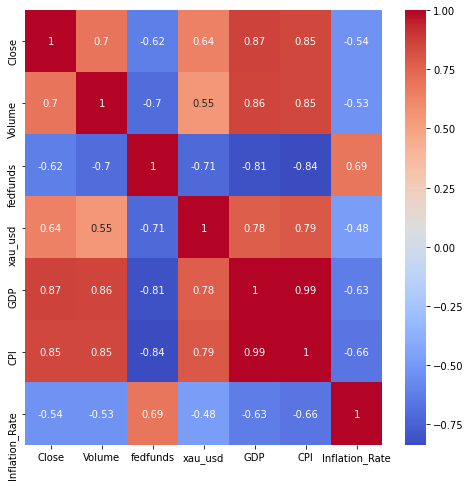

In [ ]:
plt.figure(figsize=(8,8))
sns.heatmap(all_data.corr(), annot=True, cmap='coolwarm')

In [ ]:
all_data.dtypes

Date              datetime64[ns]
Close                    float64
Volume                   float64
fedfunds                 float64
xau_usd                  float64
GDP                      float64
CPI                      float64
Inflation_Rate           float64
dtype: object

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8357 entries, 0 to 8356
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            8357 non-null   datetime64[ns]
 1   Close           8357 non-null   float64       
 2   Volume          8357 non-null   float64       
 3   fedfunds        8357 non-null   float64       
 4   xau_usd         8357 non-null   float64       
 5   GDP             8357 non-null   float64       
 6   CPI             8357 non-null   float64       
 7   Inflation_Rate  8357 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 522.4 KB


In [ ]:
all_data.describe()

,Close,Volume,fedfunds,xau_usd,GDP,CPI,Inflation_Rate
count,8357.000000,8.357000e+03,8357.000000,8357.000000,8357.000000,8357.000000,8357.000000
mean,2021.818987,1.213063e+09,3.549010,653.900360,38078.877457,179.390542,2.621790
std,1420.165013,8.426728e+08,2.759637,434.424919,12034.123978,40.434175,1.201917
min,291.899994,4.404000e+07,0.070000,252.350000,18864.605430,108.600000,-0.355546
25%,734.270020,2.731300e+08,0.400000,352.300000,26426.627895,145.800000,1.640043
50%,1900.569946,1.477150e+09,3.770000,403.300000,37180.340188,177.700000,2.805420
75%,2652.280029,1.901080e+09,5.540000,992.980000,48479.483133,216.687000,3.376857
max,6321.759766,4.553600e+09,9.850000,1901.340000,58031.414203,244.955000,5.397956


In [ ]:
all_data.shape

(8357, 8)

In [ ]:
all_data["Date"].value_counts().shape    #kaç tane unique date var

(8357,)

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8357 entries, 0 to 8356
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            8357 non-null   datetime64[ns]
 1   Close           8357 non-null   float64       
 2   Volume          8357 non-null   float64       
 3   fedfunds        8357 non-null   float64       
 4   xau_usd         8357 non-null   float64       
 5   GDP             8357 non-null   float64       
 6   CPI             8357 non-null   float64       
 7   Inflation_Rate  8357 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 522.4 KB


In [ ]:
# type(all_data["fedfunds"])   :pandas serisi
# type(all_data[["fedfunds"]]) :dataframe serisi

# all_data[["fedfunds", "GDP"]]   :grup halinde almak

# all_data[all_data["Date"] == "2011-01-05"]    :direkt o tarihi ve degerleri dondurur

# all_data[all_data["fedfunds"] > 0.16]  :fedfunds degeri 0.16'dan buyuk olan tarihleri ve dataları dondurur

In [ ]:
all_data

,Date,Close,Volume,fedfunds,xau_usd,GDP,CPI,Inflation_Rate
0,1986-01-01,325.000000,7.581000e+07,8.14,328.90,18864.605430,109.600,1.898048
1,1986-01-02,325.000000,7.581000e+07,7.86,328.90,18864.605430,109.600,3.664563
2,1986-01-03,325.700012,8.918000e+07,7.86,330.00,18864.605430,109.600,3.664563
3,1986-01-06,326.000000,9.924000e+07,7.86,330.70,18864.605430,109.600,3.664563
4,1986-01-07,329.700012,1.275000e+08,7.86,332.80,18864.605430,109.600,3.664563
...,...,...,...,...,...,...,...,...
8352,2017-07-10,6176.390137,1.675470e+09,1.15,1214.39,58031.414203,244.955,2.130110
8353,2017-07-11,6193.299805,1.808110e+09,1.15,1218.18,58031.414203,244.955,2.130110
8354,2017-07-12,6261.169922,1.820550e+09,1.15,1218.29,58031.414203,244.955,2.130110
8355,2017-07-13,6274.439941,1.803810e+09,1.15,1217.57,58031.414203,244.955,2.130110


In [ ]:
#all_data = all_data.drop(['CPI'], axis = 1)

#all_data = all_data.drop(['CPI', 'GDP'], axis = 1)
#all_data = all_data[all_data["Date"] > "2011-01-05"] 


In [ ]:
next_real_30 =  all_data[all_data["Date"] > "2017-06-14"] 
next_real_30.shape

(23, 8)

In [ ]:
all_data = all_data[all_data["Date"] < "2017-06-15"] 
all_data

,Date,Close,Volume,fedfunds,xau_usd,GDP,CPI,Inflation_Rate
0,1986-01-01,325.000000,7.581000e+07,8.14,328.90,18864.605430,109.600,1.898048
1,1986-01-02,325.000000,7.581000e+07,7.86,328.90,18864.605430,109.600,3.664563
2,1986-01-03,325.700012,8.918000e+07,7.86,330.00,18864.605430,109.600,3.664563
3,1986-01-06,326.000000,9.924000e+07,7.86,330.70,18864.605430,109.600,3.664563
4,1986-01-07,329.700012,1.275000e+08,7.86,332.80,18864.605430,109.600,3.664563
...,...,...,...,...,...,...,...,...
8329,2017-06-08,6321.759766,2.128780e+09,1.15,1277.27,58031.414203,244.955,2.130110
8330,2017-06-09,6207.919922,3.152050e+09,1.15,1267.65,58031.414203,244.955,2.130110
8331,2017-06-12,6175.459961,2.586540e+09,1.15,1266.19,58031.414203,244.955,2.130110
8332,2017-06-13,6220.370117,2.062110e+09,1.15,1266.31,58031.414203,244.955,2.130110


# To update index with Date

In [ ]:
# multi_data1 = all_data.drop(["fedfunds",	"xau_usd", "GDP",	"CPI",	"Inflation_Rate"], axis = 1)
# multi_data1 = multi_data1.set_index('Date')
# multi_data1

# Date array

In [ ]:
data_dates = all_data['Date']
data_dates

0      1986-01-01
1      1986-01-02
2      1986-01-03
3      1986-01-06
4      1986-01-07
          ...    
8329   2017-06-08
8330   2017-06-09
8331   2017-06-12
8332   2017-06-13
8333   2017-06-14
Name: Date, Length: 8334, dtype: datetime64[ns]

# Multivariate Test

Source: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [ ]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
multi_data1 = all_data.drop(["Volume","fedfunds",	"CPI","xau_usd"], axis = 1)
multi_data1 = multi_data1.set_index('Date')
multi_data1

,Close,GDP,Inflation_Rate
Date,,,
1986-01-01,325.000000,18864.605430,1.898048
1986-01-02,325.000000,18864.605430,3.664563
1986-01-03,325.700012,18864.605430,3.664563
1986-01-06,326.000000,18864.605430,3.664563
1986-01-07,329.700012,18864.605430,3.664563
...,...,...,...
2017-06-08,6321.759766,58031.414203,2.130110
2017-06-09,6207.919922,58031.414203,2.130110
2017-06-12,6175.459961,58031.414203,2.130110


In [ ]:
multi_data1.index.name = 'date'

In [ ]:
multi_data1

,Close,GDP,Inflation_Rate
date,,,
1986-01-01,325.000000,18864.605430,1.898048
1986-01-02,325.000000,18864.605430,3.664563
1986-01-03,325.700012,18864.605430,3.664563
1986-01-06,326.000000,18864.605430,3.664563
1986-01-07,329.700012,18864.605430,3.664563
...,...,...,...
2017-06-08,6321.759766,58031.414203,2.130110
2017-06-09,6207.919922,58031.414203,2.130110
2017-06-12,6175.459961,58031.414203,2.130110


In [ ]:
multi_data1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8334 entries, 1986-01-01 to 2017-06-14
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Close           8334 non-null   float64
 1   GDP             8334 non-null   float64
 2   Inflation_Rate  8334 non-null   float64
dtypes: float64(3)
memory usage: 260.4 KB


In [ ]:
multi_data1

,Close,GDP,Inflation_Rate
date,,,
1986-01-01,325.000000,18864.605430,1.898048
1986-01-02,325.000000,18864.605430,3.664563
1986-01-03,325.700012,18864.605430,3.664563
1986-01-06,326.000000,18864.605430,3.664563
1986-01-07,329.700012,18864.605430,3.664563
...,...,...,...
2017-06-08,6321.759766,58031.414203,2.130110
2017-06-09,6207.919922,58031.414203,2.130110
2017-06-12,6175.459961,58031.414203,2.130110


In [ ]:
multi_data2 = multi_data1

In [ ]:
# prepare data for lstm
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
dataset = multi_data1
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
#print(reframed.head())

In [ ]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
1,0.005489,0.0,0.391691,0.005489,0.0,0.698724
2,0.005489,0.0,0.698724,0.005605,0.0,0.698724
3,0.005605,0.0,0.698724,0.005655,0.0,0.698724
4,0.005655,0.0,0.698724,0.006269,0.0,0.698724
5,0.006269,0.0,0.698724,0.006003,0.0,0.698724
...,...,...,...,...,...,...
8329,0.995957,1.0,0.432025,1.000000,1.0,0.432025
8330,1.000000,1.0,0.432025,0.981121,1.0,0.432025
8331,0.981121,1.0,0.432025,0.975737,1.0,0.432025
8332,0.975737,1.0,0.432025,0.983185,1.0,0.432025


In [ ]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.005489        0.0   0.391691  0.005489
2   0.005489        0.0   0.698724  0.005605
3   0.005605        0.0   0.698724  0.005655
4   0.005655        0.0   0.698724  0.006269
5   0.006269        0.0   0.698724  0.006003


In [ ]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var1(t)
1,0.005489,0.0,0.391691,0.005489
2,0.005489,0.0,0.698724,0.005605
3,0.005605,0.0,0.698724,0.005655
4,0.005655,0.0,0.698724,0.006269
5,0.006269,0.0,0.698724,0.006003
...,...,...,...,...
8329,0.995957,1.0,0.432025,1.000000
8330,1.000000,1.0,0.432025,0.981121
8331,0.981121,1.0,0.432025,0.975737
8332,0.975737,1.0,0.432025,0.983185


In [ ]:
# split into train and test sets
values = reframed.values
n_train_days = 7500
train = values[:n_train_days, :]
test = values[n_train_days:, :]

In [ ]:
train.shape

(7500, 4)

In [ ]:
test.shape

(833, 4)

In [ ]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]


In [ ]:
train_X.shape

(7500, 3)

In [ ]:
train_y.shape

(7500,)

In [ ]:
test_X.shape

(833, 3)

In [ ]:
test_y.shape

(833,)

In [ ]:
test_X

array([[0.62748724, 0.9226202 , 0.08241473],
       [0.62729484, 0.9226202 , 0.08241473],
       [0.63212746, 0.9226202 , 0.08241473],
       ...,
       [0.9811206 , 1.        , 0.43202487],
       [0.97573745, 1.        , 0.43202487],
       [0.9831854 , 1.        , 0.43202487]], dtype=float32)

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(7500, 1, 3) (7500,) (833, 1, 3) (833,)


## Hyperparameter Tuning for Learning Rate

In [ ]:
# with Keras-Tuner library

In [ ]:
def build_model(hp):
    model=Sequential()
    model.add(LSTM(64,activation="tanh",return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(64,activation="tanh",return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64,activation="tanh",return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64,activation="tanh", return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    lr = hp.Float('learning_rate', 1e-4, 1e-3, sampling='log', default=1e-3)
    model.compile(
        optimizer = tf.keras.optimizers.Adam(lr),
        #optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [0.01, 0.05, 0.001, 0.005, 0.0001, 0.0005, 0.00001, 0.00005])),
        loss='mean_squared_error',
        metrics=['mean_squared_error'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=3,
    directory='my_dir_v11',
    project_name='helloworld')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 1
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.001, 'step': None, 'sampling': 'log'}


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=10,
                              mode='min', 
                              verbose=1,
                              restore_best_weights=True)

In [ ]:
tuner.search(train_X, 
             train_y, 
             epochs=50,
             batch_size = 250,
             shuffle=False,
             callbacks=[early_stopping],
             validation_data=(test_X, test_y))

Trial 20 Complete [00h 02m 03s]
val_loss: 0.00019926408519192287

Best val_loss So Far: 0.00017700722188844034
Total elapsed time: 00h 42m 29s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in my_dir_v11/helloworld
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
learning_rate: 0.0009058592365660911
Score: 0.00017700722188844034
Trial summary
Hyperparameters:
learning_rate: 0.00035971196351730075
Score: 0.00019395804459539553
Trial summary
Hyperparameters:
learning_rate: 0.000604302395008923
Score: 0.0001976428369137769
Trial summary
Hyperparameters:
learning_rate: 0.0004012413110776315
Score: 0.00019926408519192287
Trial summary
Hyperparameters:
learning_rate: 0.00039384443368573903
Score: 0.00021329987309097
Trial summary
Hyperparameters:
learning_rate: 0.000764791539967108
Score: 0.00023250377368337163
Trial summary
Hyperparameters:
learning_rate: 0.0008282135976442794
Score: 0.000244947150349617
Trial summary
Hyperparameters:
learning_rate: 0.0004192899557568033
Score: 0.000250307372577178
Trial summary
Hyperparameters:
learning_rate: 0.0004710904957936392
Score: 0.00025245098610563826
Trial summ

# batch_size hype


In [ ]:
# fit network
history = model.fit(train_X, 
                    train_y, 
                    epochs=100, 
                    batch_size=250, 
                    validation_data=(test_X, test_y), 
                    verbose=1, 
                    shuffle=False,
                    callbacks=[early_stopping])

Epoch 1/100
30/30 [==============================] - 8s 69ms/step - loss: 0.0753 - mean_squared_error: 0.0753 - val_loss: 0.5724 - val_mean_squared_error: 0.5724
Epoch 2/100
30/30 [==============================] - 0s 16ms/step - loss: 0.0645 - mean_squared_error: 0.0645 - val_loss: 0.5283 - val_mean_squared_error: 0.5283
Epoch 3/100
30/30 [==============================] - 1s 17ms/step - loss: 0.0520 - mean_squared_error: 0.0520 - val_loss: 0.4666 - val_mean_squared_error: 0.4666
Epoch 4/100
30/30 [==============================] - 1s 17ms/step - loss: 0.0381 - mean_squared_error: 0.0381 - val_loss: 0.3829 - val_mean_squared_error: 0.3829
Epoch 5/100
30/30 [==============================] - 1s 17ms/step - loss: 0.0273 - mean_squared_error: 0.0273 - val_loss: 0.2967 - val_mean_squared_error: 0.2967
Epoch 6/100
30/30 [==============================] - 1s 17ms/step - loss: 0.0241 - mean_squared_error: 0.0241 - val_loss: 0.2423 - val_mean_squared_error: 0.2423
Epoch 7/100
30/30 [=========

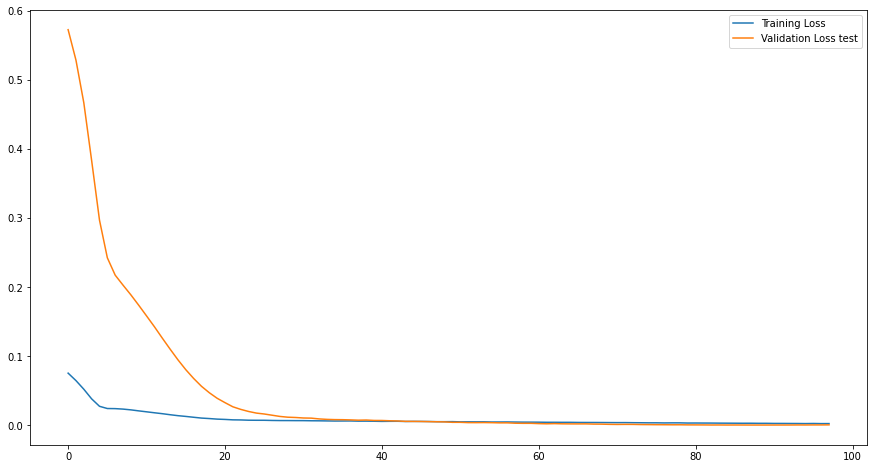

In [ ]:
# plot history
plt.figure(figsize=(15,8))
pyplot.plot(history.history['loss'], label='Training Loss')
pyplot.plot(history.history['val_loss'], label='Validation Loss test')
pyplot.legend()
pyplot.show()

In [ ]:
from numpy import concatenate
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 87.181


In [ ]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(7500, 1, 3) (7500,) (833, 3) (833, 1)


In [ ]:
yhat.shape

(833, 1)

In [ ]:
"""
yhat2 = yhat[33:]
yhat2.shape
yhat2 = yhat2.reshape((200, 1, 4))
yhat.shape , yhat2.shape
future_close = model.predict(yhat2)
future_close.shape
"""

'\nyhat2 = yhat[33:]\nyhat2.shape\nyhat2 = yhat2.reshape((200, 1, 4))\nyhat.shape , yhat2.shape\nfuture_close = model.predict(yhat2)\nfuture_close.shape\n'

In [ ]:
yhat.size

833

In [ ]:
new_test_data2 = pd.DataFrame(yhat, columns = ["yhat"])
new_test_data2

,yhat
0,0.614986
1,0.614825
2,0.618869
3,0.620401
4,0.622195
...,...
828,1.002208
829,1.006370
830,0.986978
831,0.981468


In [ ]:
size_bound = reframed["var2(t-1)"].size-yhat.size
reframed_for_test4 = reframed[["var2(t-1)","var3(t-1)"]][size_bound:]
reframed_for_test4 =  reframed_for_test4.reset_index()
reframed_for_test4.drop(["index"], axis=1, inplace=True)
reframed_for_test4

,var2(t-1),var3(t-1)
0,0.92262,0.082415
1,0.92262,0.082415
2,0.92262,0.082415
3,0.92262,0.082415
4,0.92262,0.082415
...,...,...
828,1.00000,0.432025
829,1.00000,0.432025
830,1.00000,0.432025
831,1.00000,0.432025


In [ ]:
new_test_data2, reframed_for_test4

(         yhat
 0    0.614986
 1    0.614825
 2    0.618869
 3    0.620401
 4    0.622195
 ..        ...
 828  1.002208
 829  1.006370
 830  0.986978
 831  0.981468
 832  0.989094
 
 [833 rows x 1 columns],      var2(t-1)  var3(t-1)
 0      0.92262   0.082415
 1      0.92262   0.082415
 2      0.92262   0.082415
 3      0.92262   0.082415
 4      0.92262   0.082415
 ..         ...        ...
 828    1.00000   0.432025
 829    1.00000   0.432025
 830    1.00000   0.432025
 831    1.00000   0.432025
 832    1.00000   0.432025
 
 [833 rows x 2 columns])

In [ ]:
data_for_future_test = pd.concat([new_test_data2, reframed_for_test4], axis=1)
data_for_future_test 

,yhat,var2(t-1),var3(t-1)
0,0.614986,0.92262,0.082415
1,0.614825,0.92262,0.082415
2,0.618869,0.92262,0.082415
3,0.620401,0.92262,0.082415
4,0.622195,0.92262,0.082415
...,...,...,...
828,1.002208,1.00000,0.432025
829,1.006370,1.00000,0.432025
830,0.986978,1.00000,0.432025
831,0.981468,1.00000,0.432025


In [ ]:
data_for_future_test_arr = data_for_future_test.to_numpy()
data_for_future_test_arr

array([[0.61498606, 0.9226202 , 0.08241473],
       [0.61482537, 0.9226202 , 0.08241473],
       [0.61886907, 0.9226202 , 0.08241473],
       ...,
       [0.9869781 , 1.        , 0.43202487],
       [0.9814676 , 1.        , 0.43202487],
       [0.9890942 , 1.        , 0.43202487]], dtype=float32)

In [ ]:
data_for_future_test_arr = data_for_future_test_arr.reshape((data_for_future_test.shape[0], 1, data_for_future_test.shape[1]))
data_for_future_test_arr.shape

(833, 1, 3)

In [ ]:
prr1 = model.predict(data_for_future_test_arr)

In [ ]:
inverse_future_preds = concatenate((prr1, test_X[:, 1:]), axis=1)
inverse_future_preds = scaler.inverse_transform(inverse_future_preds)
inverse_future_preds = inverse_future_preds[:,0][-30:]
inverse_future_preds

array([6138.065 , 6140.96  , 6167.3765, 6169.3535, 6188.031 , 6196.948 ,
       6183.205 , 6188.6978, 6218.388 , 6239.5264, 6074.6396, 6120.004 ,
       6149.641 , 6201.622 , 6206.936 , 6232.355 , 6276.658 , 6281.839 ,
       6274.4824, 6274.4824, 6269.578 , 6320.429 , 6382.81  , 6372.0825,
       6350.251 , 6373.8823, 6399.7515, 6279.453 , 6245.3833, 6292.5493],
      dtype=float32)

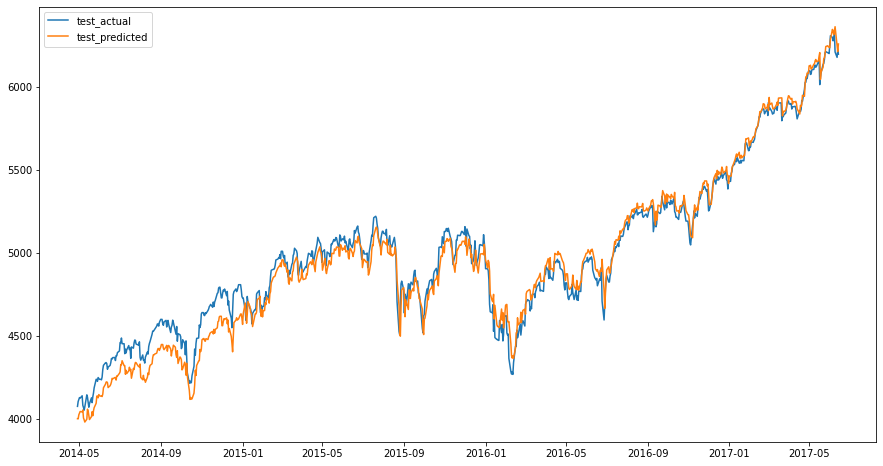

In [ ]:
;# plot train result 
plt.figure(figsize=(15,8))
pyplot.plot(data_dates[(train_y.size+1):], inv_y, label='test_actual')
pyplot.plot(data_dates[(train_y.size+1):], inv_yhat, label='test_predicted')
pyplot.legend()
pyplot.show()

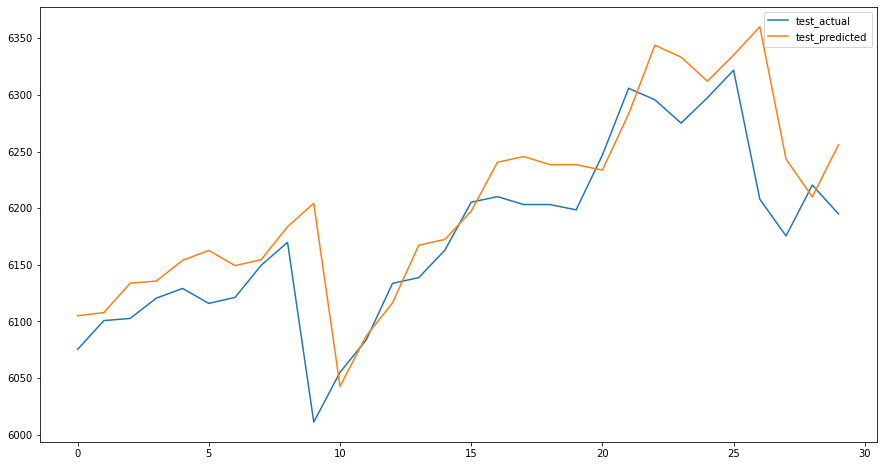

In [ ]:
;# plot train result 
plt.figure(figsize=(15,8))
pyplot.plot(inv_y[-30:], label='test_actual')
pyplot.plot( inv_yhat[-30:], label='test_predicted')
pyplot.legend()
pyplot.show()

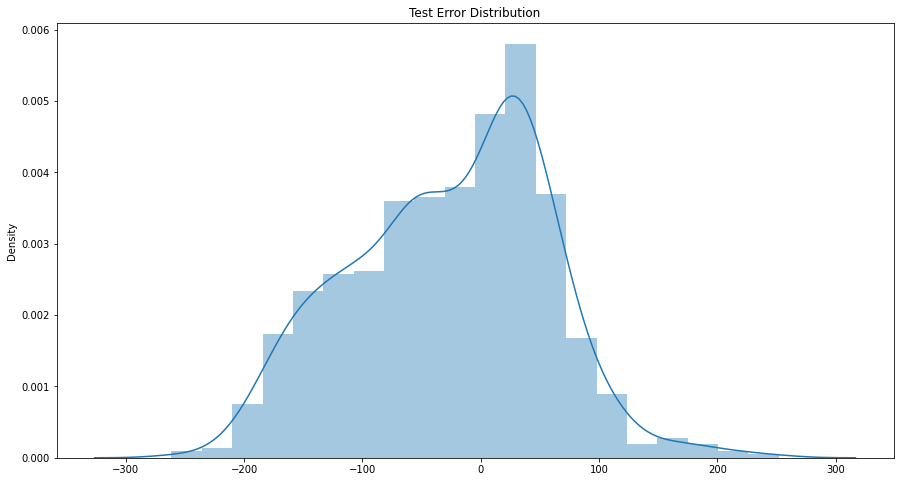

In [ ]:
#Test Error
plt.figure(figsize=(15,8))    

sns.distplot(inv_yhat - inv_y)
plt.title('Test Error Distribution')
plt.show()

# Dates of Predictions

In [ ]:
n_steps = 30
day_new=np.arange(1,n_steps+1)
day_pred=np.arange(n_steps+1,n_steps+31)
day_new2 = data_dates[len(multi_data1)-n_steps:]
day_new2 = day_new2.array
day_new2

<DatetimeArray>
['2017-05-04 00:00:00', '2017-05-05 00:00:00', '2017-05-08 00:00:00',
 '2017-05-09 00:00:00', '2017-05-10 00:00:00', '2017-05-11 00:00:00',
 '2017-05-12 00:00:00', '2017-05-15 00:00:00', '2017-05-16 00:00:00',
 '2017-05-17 00:00:00', '2017-05-18 00:00:00', '2017-05-19 00:00:00',
 '2017-05-22 00:00:00', '2017-05-23 00:00:00', '2017-05-24 00:00:00',
 '2017-05-25 00:00:00', '2017-05-26 00:00:00', '2017-05-29 00:00:00',
 '2017-05-30 00:00:00', '2017-05-31 00:00:00', '2017-06-01 00:00:00',
 '2017-06-02 00:00:00', '2017-06-05 00:00:00', '2017-06-06 00:00:00',
 '2017-06-07 00:00:00', '2017-06-08 00:00:00', '2017-06-09 00:00:00',
 '2017-06-12 00:00:00', '2017-06-13 00:00:00', '2017-06-14 00:00:00']
Length: 30, dtype: datetime64[ns]

In [ ]:
import datetime
first_day_of_prediction = day_new2[-1] + datetime.timedelta(days=1)

end_day_of_prediction = day_new2[-1] + datetime.timedelta(days=30)
first_day_of_prediction, end_day_of_prediction

(Timestamp('2017-06-15 00:00:00'), Timestamp('2017-07-14 00:00:00'))

In [ ]:
day_pred2 = pd.Series(pd.date_range(first_day_of_prediction, freq="D", periods=len(inv_yhat[-30:]))).array
day_pred2

<DatetimeArray>
['2017-06-15 00:00:00', '2017-06-16 00:00:00', '2017-06-17 00:00:00',
 '2017-06-18 00:00:00', '2017-06-19 00:00:00', '2017-06-20 00:00:00',
 '2017-06-21 00:00:00', '2017-06-22 00:00:00', '2017-06-23 00:00:00',
 '2017-06-24 00:00:00', '2017-06-25 00:00:00', '2017-06-26 00:00:00',
 '2017-06-27 00:00:00', '2017-06-28 00:00:00', '2017-06-29 00:00:00',
 '2017-06-30 00:00:00', '2017-07-01 00:00:00', '2017-07-02 00:00:00',
 '2017-07-03 00:00:00', '2017-07-04 00:00:00', '2017-07-05 00:00:00',
 '2017-07-06 00:00:00', '2017-07-07 00:00:00', '2017-07-08 00:00:00',
 '2017-07-09 00:00:00', '2017-07-10 00:00:00', '2017-07-11 00:00:00',
 '2017-07-12 00:00:00', '2017-07-13 00:00:00', '2017-07-14 00:00:00']
Length: 30, dtype: datetime64[ns]

In [ ]:
def real_results_prediction(table):
    table = table.loc[(table['Date'] >= first_day_of_prediction) & (table['Date'] <= end_day_of_prediction)] 
    table.reset_index(inplace=True, drop=True)
    return table
nasdaq_comparison = real_results_prediction(nasdaq_all)
nasdaq_comparison

,Date,Close,Volume
0,2017-06-15,6165.500000,1858130000
1,2017-06-16,6151.759766,3120640000
2,2017-06-19,6239.009766,1976970000
3,2017-06-20,6188.029785,2570130000
4,2017-06-21,6233.950195,2401440000
5,2017-06-22,6236.689941,2170250000
6,2017-06-23,6265.250000,2704600000
7,2017-06-26,6247.149902,2150630000
8,2017-06-27,6146.620117,2181830000
9,2017-06-28,6234.410156,2069400000


In [ ]:
data = {'Date':  day_pred2}

prediction_data = pd.DataFrame (data, columns = ['Date'])

prediction_data['Predictions'] = inverse_future_preds
prediction_data

,Date,Predictions
0,2017-06-15,6138.064941
1,2017-06-16,6140.959961
2,2017-06-17,6167.376465
3,2017-06-18,6169.353516
4,2017-06-19,6188.030762
5,2017-06-20,6196.948242
6,2017-06-21,6183.205078
7,2017-06-22,6188.697754
8,2017-06-23,6218.388184
9,2017-06-24,6239.526367


In [ ]:
comparison_data = pd.merge(prediction_data, nasdaq_comparison, how ="outer", on=["Date"]) 
comparison_data.update(comparison_data.Close.interpolate())
comparison_data = comparison_data[['Date', 'Predictions', 'Close']]
comparison_data

,Date,Predictions,Close
0,2017-06-15,6138.064941,6165.500000
1,2017-06-16,6140.959961,6151.759766
2,2017-06-17,6167.376465,6180.843099
3,2017-06-18,6169.353516,6209.926433
4,2017-06-19,6188.030762,6239.009766
5,2017-06-20,6196.948242,6188.029785
6,2017-06-21,6183.205078,6233.950195
7,2017-06-22,6188.697754,6236.689941
8,2017-06-23,6218.388184,6265.250000
9,2017-06-24,6239.526367,6259.216634


# Evaluation of Prediction Results

In [ ]:
mse_of_pred = math.sqrt(mean_squared_error(comparison_data.Close,comparison_data.Predictions))
mse_of_pred

122.56867346690493

In [ ]:
rmse_of_pred = math.sqrt(mse_of_pred)
rmse_of_pred

11.0710737269203

Kök Ortalama Karekök Hatası (RMSE), MSE’nin kareköküdür. MSE’den daha sık kullanılır çünkü bazen MSE değeri kolayca karşılaştırılamayacak kadar büyük olabilir. Bu yüzden MSE hata karesi ile hesaplanır ve böylece yorumlamayı kolaylaştırır. Fakat MSE aykırı değerlere karşı çok duyarlıdır.

## Graphs of Prediction Results

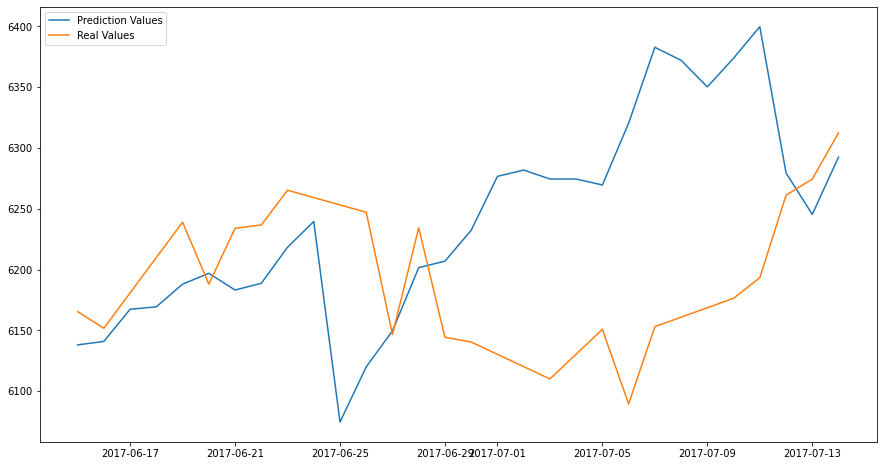

In [ ]:
# Graph of next 30 days prediction
plt.figure(figsize=(15,8)) 

plt.plot(day_pred2, comparison_data.Predictions, label = 'Prediction Values')
plt.plot(day_pred2, comparison_data.Close, label = 'Real Values')
plt.legend();